# TempEst-NEWT Case Studies

This Notebook covers preliminary data exploration through case studies to inform development of the watershed-scale component of the TempEst-NEXT model.

In [111]:
import pandas as pd
import pandas.plotting as pdp
import numpy as np
import matplotlib.pyplot as plt
import rtseason as rts

In [29]:
base_path = r"X:\Rio.Data\StreamTemperature\NEXT\ReadyData\daymet_aoi"
gsamp = pd.read_csv(r"C:\Users\dphilippus\OneDrive - Colorado School of Mines\PhD\NEXT\DataRetrieval\GageSample.csv",
                   dtype={"id": "str"})

In [30]:
def get_candidate(cid):
    data = pd.read_csv(r"C:\Users\dphilippus\OneDrive - Colorado School of Mines\PhD\NEXT\DataRetrieval\AllGageData.csv",
                      dtype={"id": "str"})
    data["date"] = pd.to_datetime(data["date"])
    weather_path = base_path + "\\USGS-" + cid + ".csv"
    weather = pd.read_csv(weather_path)
    stdat = data[data["id"] == candidate]
    weather["date"] = pd.to_datetime(weather["datetime"]).dt.normalize()
    wmean = weather.pivot(index="date", columns="variable", values="mean")
    return stdat[["date", "temperature.mean"]].merge(wmean, on="date")

In [31]:
# This is Eagle River Below Milk Creek Near Wolcott, CO
# Appears to be unregulated, freezes in winter, max temperature ~20 C, discharge ~50-2000 cfs,
# elevation ~2100 m
candidate_eagle = "394220106431500"

cid = candidate_eagle
csd = get_candidate(cid)

# Begin Analysis

Now, the data is prepared (`csd`): we have date, mean temperature, and weather variables.  This particular site has ~15 years of data.

<Axes: xlabel='date'>

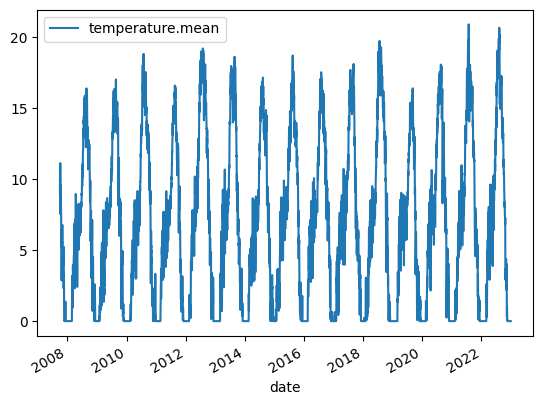

In [32]:
csd.plot.line(x="date", y="temperature.mean")

In a win for the three-sine model, the general form of the annual temperature cycle - with a clear spring-low - is quite distinct.  The question is whether that seasonal variation can be captured in a pseudophysical-statistical model or whether it requires direct approximation, TempEst 2-style.

<Axes: xlabel='tmax', ylabel='temperature.mean'>

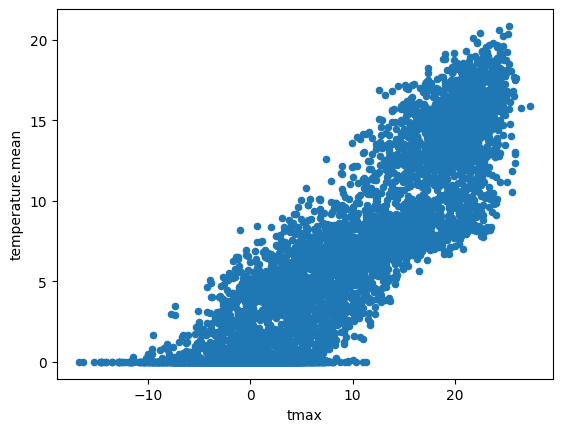

In [33]:
csd.plot.scatter(x="tmax", y="temperature.mean")

In [34]:
csd["DeltaT"] = csd["temperature.mean"].diff()
csd["DeltaAT"] = csd["tmax"].diff()

<Axes: xlabel='tmax', ylabel='DeltaT'>

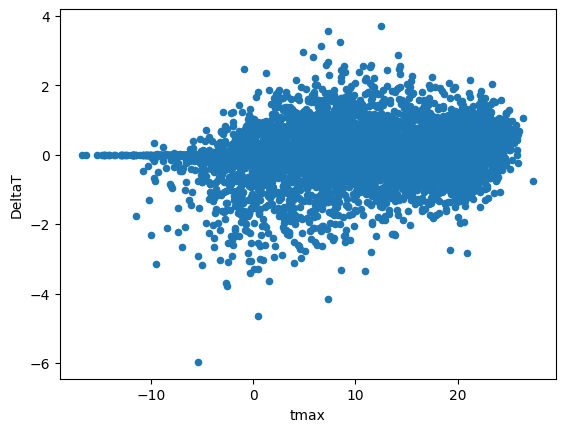

In [35]:
csd.plot.scatter(x="tmax", y="DeltaT")

<Axes: xlabel='swe', ylabel='temperature.mean'>

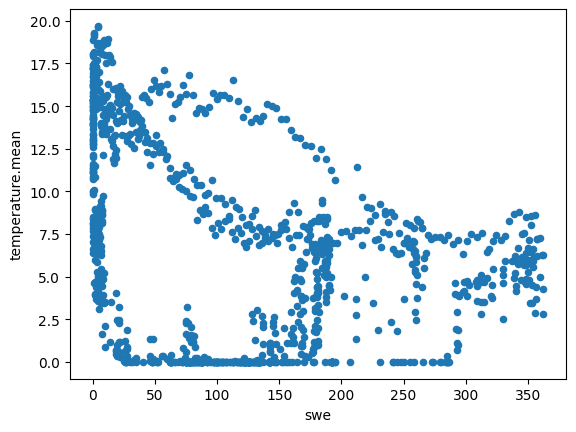

In [36]:
csd.plot.scatter(x="swe", y="temperature.mean")

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

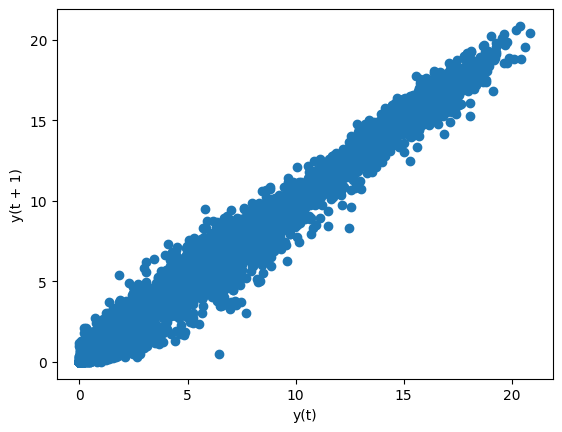

In [37]:
pdp.lag_plot(csd["temperature.mean"])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

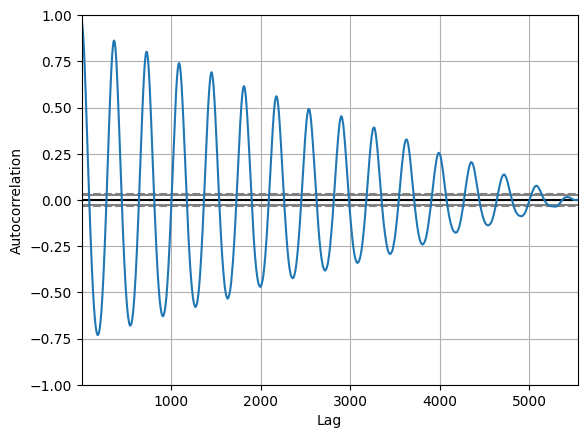

In [38]:
pdp.autocorrelation_plot(csd["temperature.mean"])

<Axes: xlabel='temperature.mean', ylabel='tmax'>

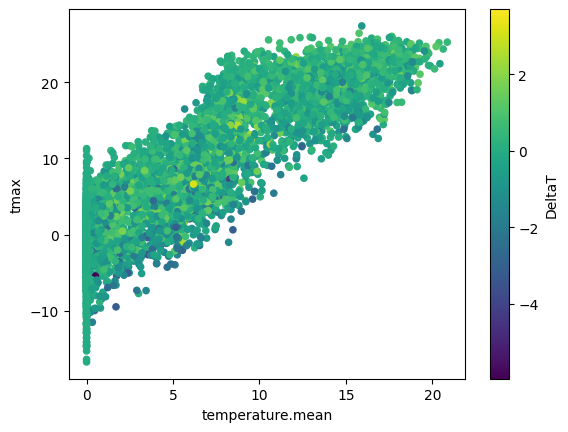

In [39]:
csd.plot.scatter(x="temperature.mean", y="tmax", c="DeltaT")

In [40]:
csd["doy"] = csd["date"].dt.day_of_year

<Axes: xlabel='doy', ylabel='DeltaT'>

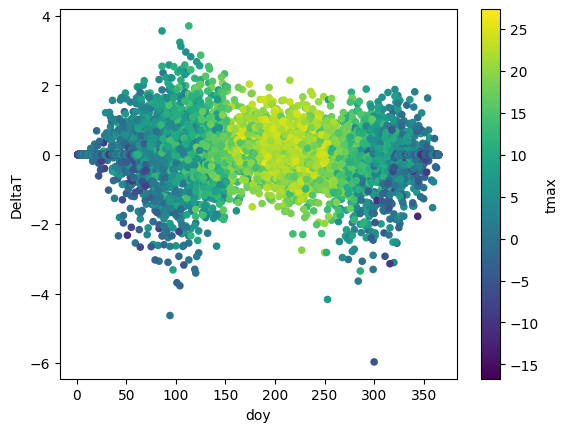

In [41]:
csd.plot.scatter(x="doy", c="tmax", y="DeltaT")

<Axes: xlabel='prcp', ylabel='DeltaT'>

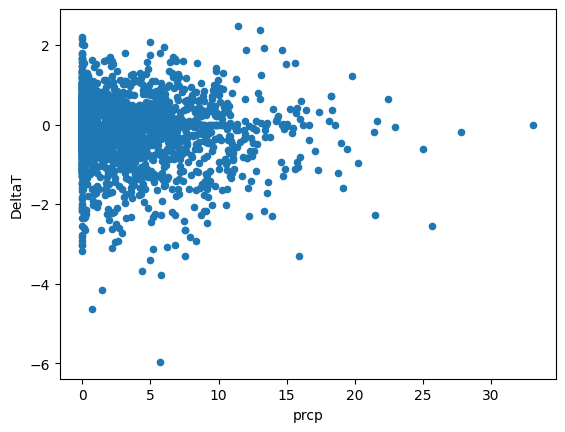

In [42]:
csd[csd["DeltaAT"] < 0].plot.scatter(x="prcp", y="DeltaT")

For Eagle River, the optimal correlation åååååååååååååååååååååååååååååååååååååååååååååååååååååååååååmean water temperature.  Unsurprisingly, this has a sigmoidal form, but interestingly, it's actually flipped: rolling tmax appears to be a sigmoid of water temperature, not the other way around!  Now, when we color it by day-of-year, the pattern gains some clarity, and we see that the sigmoid actually reflects hysteresis driven by day-of-year norms, with the air temperature driving scatter more than the overall form.  The pattern is slightly noisier, but more obvious, using tmean (mean of minimum and maximum).

From the start of the year, water temperature increases linearly from zero to about 7-8 C while mean air temperatures increase to 0 C.  After that, the snowmelt dominates until air temperatures hit 10 C (a threshold which is probably driven by the amount of snow, not an exact number for air temperature), and water temperatures are nearly constant, with a very slight linear trend.  From air temperatures of 10-15 C (the maximum), there is a faster linear increase in water temperatures up to the maximum of about 18 C.  Then there's a steady, nearly linear (with a slight positive second derivative) decline back to 0 C, which seems to hit when air temperatures are consistently a little below freezing.

Some takeaways:

- The water is almost always *warmer* than the mean daily air temperature, presumably due to solar radiation (year-round), freezing, and groundwater (in colder months).
- Water warms up before the whole basin thaws.  Presumably, there's quite a bit of in-channel warming and warmer runoff in the lower part of the basin.
- The major snowmelt pulse fixes temperatures.  Seasonality of this could be estimated from basin characteristics, but it's worth seeing if there's a better way to do that using dynamic data.  A few thoughts:
  - Does this always happen (in snowy watersheds) at AT=0 C, or is there some other threshold?
  - Can we predict when it unsticks?  Is there a consistent snowpack or temperature threshold?
- The cooling limb of the thermograph (is there a word for that?) could be approximated quite accurately by a linear function from the maximum annual temperature down to the minimum, but we need a generic way to get the maximum and minimum coordinates.

Broadly, the seasonality is so dominant that a SCHEMA-like approach will almost certainly get the best performance, but I want to stay away from a stationary estimate of seasonality.  Instead, I should see if it's possible to dynamically identify seasonality thresholds and apply specialized regressions accordingly - assuming, of course, that this sort of pattern holds up.

                    RollAT  temperature.mean
RollAT            1.000000          0.864708
temperature.mean  0.864708          1.000000


<Axes: xlabel='RollAT', ylabel='temperature.mean'>

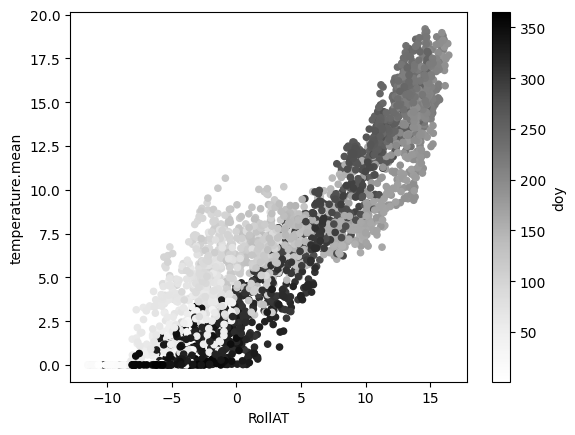

In [86]:
roll = 18  # best correlation
csd["RollAT"] = ((csd["tmax"] + csd["tmin"])/2).rolling(roll).mean()
print(csd[["RollAT", "temperature.mean"]].corr()**2)
csd.plot.scatter(x="RollAT", y="temperature.mean", c="doy")

In [121]:
csdssn = csd[["doy", "temperature.mean"]].rename(columns={"doy": "day", "temperature.mean": "temperature"})
ssn = rts.ThreeSine.from_data(csdssn.dropna()).generate_ts()
fitted = csdssn.merge(ssn, on="day")
fitted[["temperature", "actemp"]].corr()**2

,temperature,actemp
temperature,1.000000,0.927741
actemp,0.927741,1.000000


<Axes: xlabel='doy', ylabel='temperature.mean'>

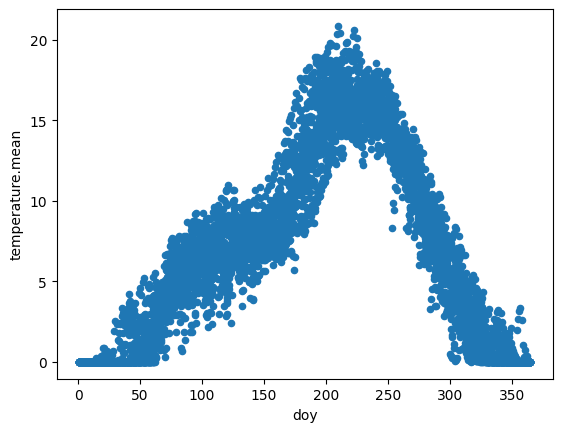

In [117]:
csd.plot.scatter(x="doy", y="temperature.mean")

Let's look at some specific years.

Overall:

- Warming started at -5 or -6 in 6/9 full-coverage years, but it could start as low as -10.
- Melt temperature was almost always 7-8 C, but some years had spikes above that and 2012 had no identifiable melt (low snow year?)
- Melt fixing began at about 0 C and ended at 8-10 C.
- Maximum water temperature was generally just slightly above maximum sustained air temperature.
- Freeze occurred between (0, 0) and (-5, 0).

In [87]:
csd["year"] = csd["date"].dt.year

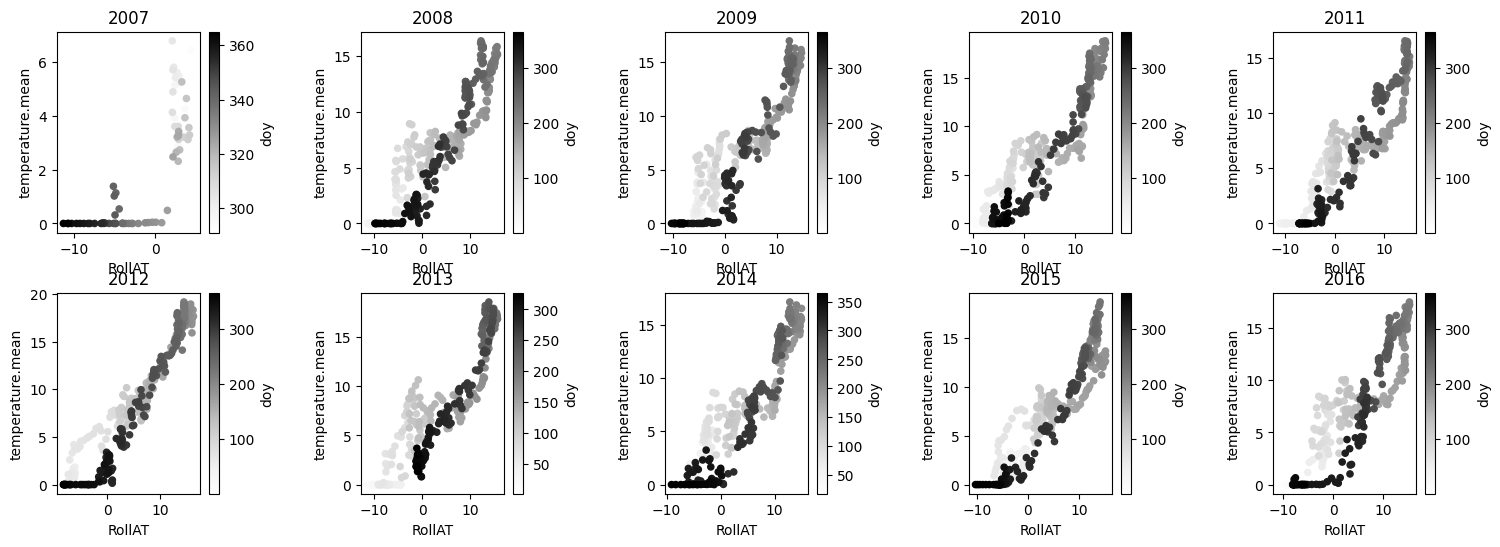

In [109]:
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(18,6))
plt.subplots_adjust(wspace=0.7, hspace=0.3)
for year in range(2007, 2017):
    x = (year - 2007) // 5
    y = (year - 2007) % 5
    csd[csd["year"]==year].plot.scatter(x="RollAT", y="temperature.mean", c="doy", ax=axes[x, y])
    axes[x, y].set_title(str(year))